In [38]:
#PACKAGES

import pandas as pd
import yfinance as yf
import talib
import numpy as np
import requests
from io import StringIO
from datetime import date, datetime, timedelta
import praw
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [39]:
#DATA

portfolio_df = pd.read_csv("/Users/pedroalexleite/Desktop/Portfolio-Construction-1/Data/portfolio.csv")

analysis_dict = {
    'Fundamental': {
        'weight': 0.5,
        'categories': {
            'Evaluation': {
                'weight': 0.4,
                'variables': ['PER', 'PEGR', 'PBR', 'DY', 'EV/EBITDA', 'P/S']
            },
            'Profitability': {
                'weight': 0.2,
                'variables': ['ROA', 'NPM']
            },
            'Financial Health': {
                'weight': 0.2,
                'variables': ['ICR', 'FCF']
            },
            'Growth': {
                'weight': 0.2,
                'variables': ['RGR', 'EGR']
            }
        }
    },
    'Technical': {
        'weight': 0.3,
        'categories': {
            'Trend': {
                'weight': 0.5,
                'variables': ['SMA', 'EMA', 'MACD', 'ADX']
            },
            'Momentum': {
                'weight': 0.3,
                'variables': ['RSI', 'ROC']
            },
            'Volume': {
                'weight': 0.2,
                'variables': ['OBV', 'MFI']
            }
        }
    },
    'Sentimental': {
        'weight': 0.2,
        'categories': {
            'Social Media': {
                'weight': 1.0,
                'variables': ['r/wallstreetbets']
            }
        }
    }
}

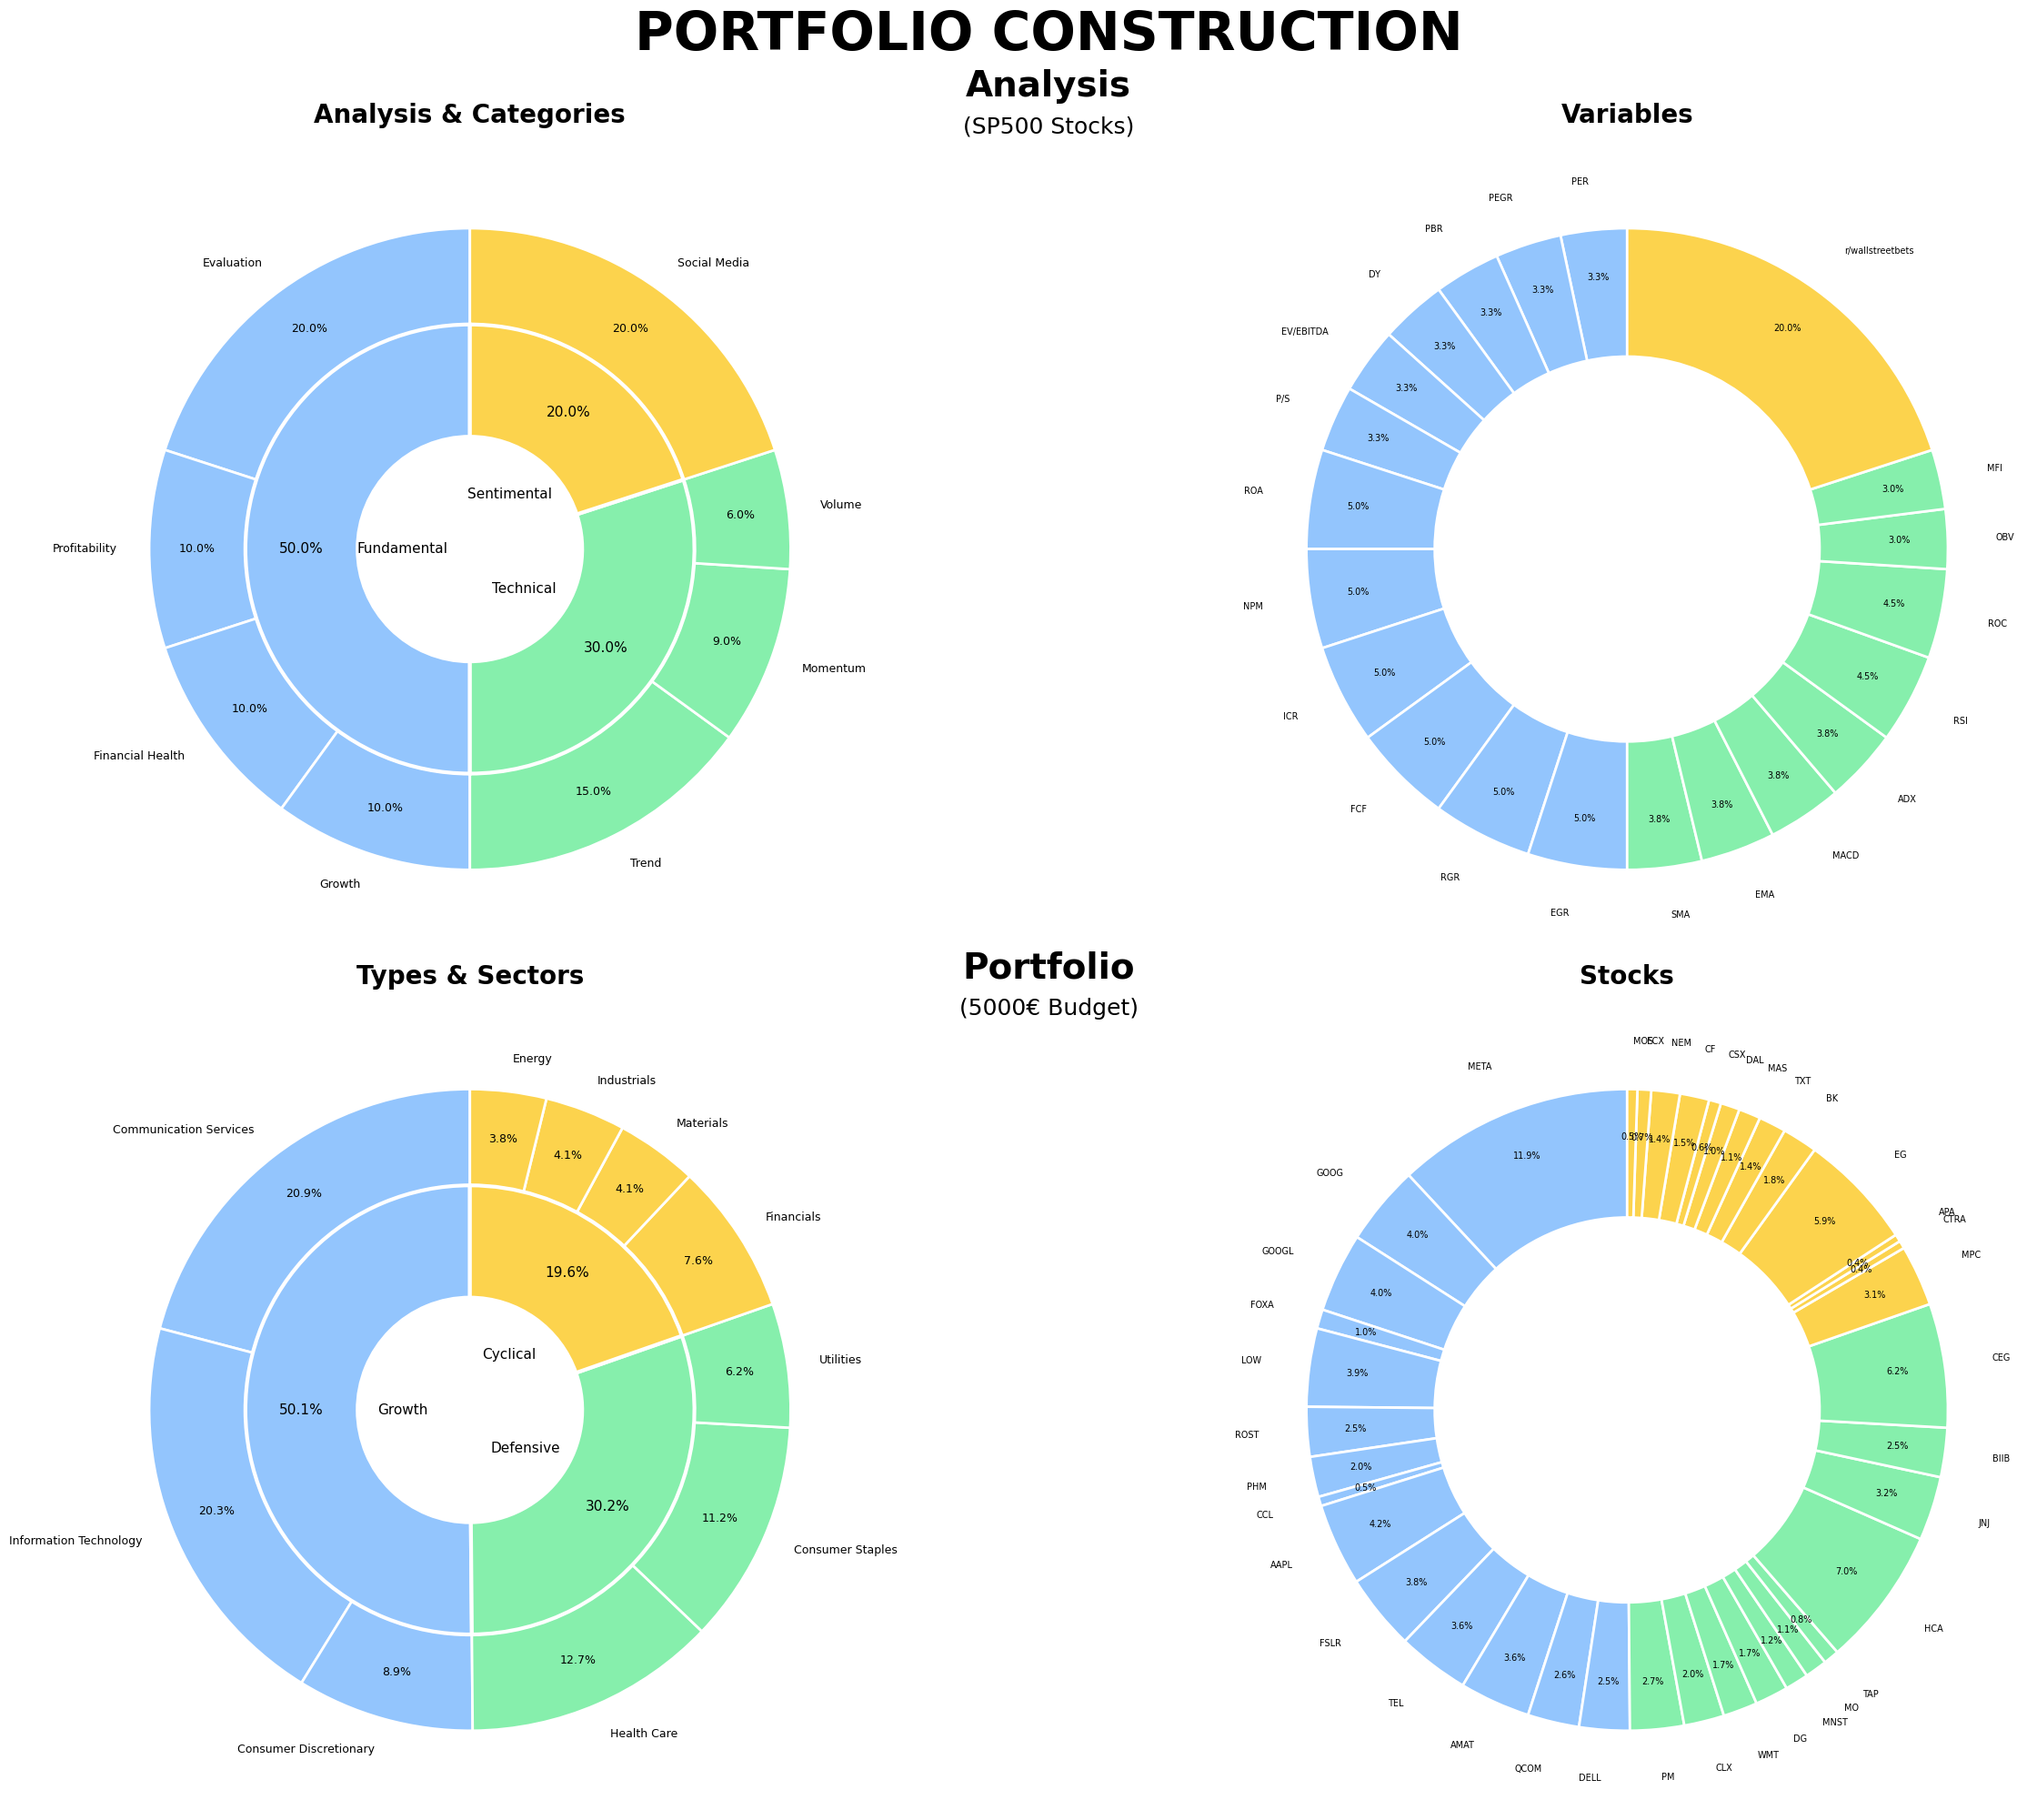

In [40]:
#VISUALIZATION

def visualization(analysis_dict, portfolio_df, save_path=None):
    type_color_map_analysis = {
        'Fundamental': '#93C5FD',
        'Technical': '#86EFAC',
        'Sentimental': '#FCD34D'
    }
    
    type_color_map_portfolio = {
        'Growth': '#93C5FD',     
        'Defensive': '#86EFAC', 
        'Cyclical': '#FCD34D'     
    }
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(28, 20))
    
    #analysis & categories
    category_data = []
    category_labels = []
    category_colors = []
    
    type_order = ['Fundamental', 'Technical', 'Sentimental']
    
    for typ in type_order:
        type_weight = data[typ]['weight']
        base_color = type_color_map_analysis[typ]
        
        for category, cat_info in data[typ]['categories'].items():
            category_value = type_weight * cat_info['weight']
            category_data.append(category_value)
            category_labels.append(category)
            category_colors.append(base_color)
    
    wedges1, texts1, autotexts1 = ax1.pie(
        category_data,
        labels=category_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=category_colors,
        pctdistance=0.85,
        radius=1,
        wedgeprops=dict(width=0.3, edgecolor='white', linewidth=2),
        textprops={'size': 9}
    )
    
    type_values = [data[t]['weight'] for t in type_order]
    type_colors = [type_color_map_analysis[t] for t in type_order]
    
    wedges2, texts2, autotexts2 = ax1.pie(
        type_values,
        labels=type_order,
        autopct='%1.1f%%',
        startangle=90,
        colors=type_colors,
        pctdistance=0.75,
        labeldistance=0.30,
        radius=0.7,
        wedgeprops=dict(width=0.35, edgecolor='white', linewidth=3),
        textprops={'size': 11}
    )
    
    for text in texts2:
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
    
    for autotext in autotexts1:
        autotext.set_color('black')
        autotext.set_fontsize(9)
    
    for autotext in autotexts2:
        autotext.set_color('black')
        autotext.set_fontsize(11)
    
    ax1.set_title('Analysis & Categories', fontsize=20, weight='bold', pad=20)
    
    #vriables
    variable_data = []
    variable_labels = []
    variable_colors = []
    
    for typ in type_order:
        type_weight = data[typ]['weight']
        base_color = type_color_map_analysis[typ]
        
        for category, cat_info in data[typ]['categories'].items():
            category_weight = type_weight * cat_info['weight']
            num_vars = len(cat_info['variables'])
            
            for var in cat_info['variables']:
                var_value = category_weight / num_vars
                variable_data.append(var_value)
                variable_labels.append(var)
                variable_colors.append(base_color)
    
    wedges3, texts3, autotexts3 = ax2.pie(
        variable_data,
        labels=variable_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=variable_colors,
        pctdistance=0.85,
        labeldistance=1.15,
        wedgeprops=dict(width=0.4, edgecolor='white', linewidth=2),
        textprops={'size': 7}
    )
    
    for autotext in autotexts3:
        autotext.set_color('black')
        autotext.set_fontsize(7)
    
    ax2.set_title('Variables', fontsize=20, weight='bold', pad=20)

    #------------------------------------------------------------------------------------
    
    type_order_portfolio = ['Growth', 'Defensive', 'Cyclical']
    
    #types & sectors
    sector_data = []
    sector_labels = []
    sector_colors = []
    
    for typ in type_order_portfolio:
        type_sectors = portfolio_df[portfolio_df['Type'] == typ].groupby('Sector')['Investment'].sum()
        type_sectors = type_sectors.sort_values(ascending=False)
        base_color = type_color_map_portfolio.get(typ, '#Gray')
        
        for sector, value in type_sectors.items():
            sector_data.append(value)
            sector_labels.append(sector)
            sector_colors.append(base_color)
    
    wedges4, texts4, autotexts4 = ax3.pie(
        sector_data,
        labels=sector_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=sector_colors,
        pctdistance=0.85,
        radius=1,
        wedgeprops=dict(width=0.3, edgecolor='white', linewidth=2),
        textprops={'size': 9}
    )
    
    type_inv_ordered = portfolio_df.groupby('Type')['Investment'].sum().reindex(type_order_portfolio)
    type_colors_portfolio = [type_color_map_portfolio.get(t, '#Gray') for t in type_order_portfolio]
    
    wedges5, texts5, autotexts5 = ax3.pie(
        type_inv_ordered.values,
        labels=type_inv_ordered.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=type_colors_portfolio,
        pctdistance=0.75,
        labeldistance=0.30,
        radius=0.7,
        wedgeprops=dict(width=0.35, edgecolor='white', linewidth=3),
        textprops={'size': 11}
    )
    
    for text in texts5:
        text.set_horizontalalignment('center')
        text.set_verticalalignment('center')
    
    for autotext in autotexts4:
        autotext.set_color('black')
        autotext.set_fontsize(9)
    
    for autotext in autotexts5:
        autotext.set_color('black')
        autotext.set_fontsize(11)
    
    ax3.set_title('Types & Sectors', fontsize=20, weight='bold', pad=20)
    
    #stocks
    portfolio_df['Type_order'] = portfolio_df['Type'].map({t: i for i, t in enumerate(type_order_portfolio)})
    sorted_df = portfolio_df.sort_values(['Type_order', 'Sector', 'Investment'], ascending=[True, True, False]).reset_index(drop=True)
    
    symbol_data = sorted_df['Investment'].values
    symbol_labels = sorted_df['Symbol'].values
    symbol_colors = [type_color_map_portfolio.get(typ, '#Gray') for typ in sorted_df['Type']]
    
    wedges6, texts6, autotexts6 = ax4.pie(
        symbol_data,
        labels=symbol_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=symbol_colors,
        pctdistance=0.85,
        labeldistance=1.15,
        wedgeprops=dict(width=0.4, edgecolor='white', linewidth=2),
        textprops={'size': 7}
    )
    
    for autotext in autotexts6:
        autotext.set_color('black')
        autotext.set_fontsize(7)
    
    ax4.set_title('Stocks', fontsize=20, weight='bold', pad=20)

    fig.suptitle('PORTFOLIO CONSTRUCTION', fontsize=42, weight='bold', y=0.998)

    fig.text(0.5, 0.95, 'Analysis', ha='center', fontsize=28, weight='bold')
    fig.text(0.5, 0.93, '(SP500 Stocks)', ha='center', fontsize=18)
    
    fig.text(0.5, 0.465, 'Portfolio', ha='center', fontsize=28, weight='bold')
    fig.text(0.5, 0.445, '(5000€ Budget)', ha='center', fontsize=18)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

visualization(analysis_dict, portfolio_df)

In [41]:
#SAVE 

visualization(analysis_dict, portfolio_df, save_path="/Users/pedroalexleite/Desktop/Portfolio-Construction-1/Data/visualization.png")